In [1]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

from scipy.fft import fft, ifft, fftfreq
from fooof import FOOOF
from fooof.core.funcs import expo_function

from neurodsp.sim import sim_bursty_oscillation, sim_oscillation
from neurodsp.spectral import compute_spectrum

from timescales.sim import sim_spikes_synaptic, exp_decay_func, sim_acf_cos
from timescales.est import compute_acf, fit_acf, fit_acf_cos, fit_psd, convert_knee_val

## Manuscript Figures

### Figure 1

Timscale Methods & Applications

- Traditional ACF approach
    - Avg. ACF of population
- Related Errors
    - Bias (Bayes paper) <- need to implement
        - ~~Limits event-related application~~
        - Multiple Trials (ACF vs Spectral)
    - Oscillations
        - SpecParam
        - ACF + Cos
        
Below, each trace is a separate neuron (equivalent to a separate trial). 100 neurons/trials are simulated, each with 2s of signal, simulating an event-related design.

In [2]:
# Settings
n_seconds = 2
fs = 1000
tau = 0.025
var_noise = None
n_trials = 100 # could also be interpreted as independent neurons

# Simulate Spikes
spikes = np.zeros((n_trials, int(n_seconds * fs)))
spikes_osc = np.zeros((n_trials, int(n_seconds * fs)))

for i in range(n_trials):
    
    _probs, _spikes = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=1,
                                          mu=10, var_noise=var_noise, return_sum=False)
    
    spikes[i] = _probs
    
    # Add oscillation
    _cos = sim_oscillation(n_seconds, fs, 10, phase='max')
    _cos -= _cos.min()
    _cos /= _cos.max()
    
    spikes_osc[i] = _probs + (_cos * .25)
    spikes_osc[i] = spikes_osc[i] / np.max(spikes_osc[i])
    
# Compute ACF
corrs = compute_acf(spikes, 500)
params_acf = fit_acf(corrs, fs)
params_acf_mean = fit_acf(corrs.mean(axis=0), fs)

corrs_osc = compute_acf(spikes_osc, 500)
params_acf_osc = fit_acf_cos(corrs_osc, fs)
params_acf_mean_osc = fit_acf_cos(corrs_osc.mean(axis=0), fs)

# Fit Spectra
f_range = (1, 100)
fooof_init = {'max_n_peaks': 0}
freqs, powers = compute_spectrum(spikes, fs)
fg, knee_freq, knee_tau = fit_psd(freqs, powers, f_range, fooof_init)
fg_mean, knee_freq_mean, knee_tau_mean = fit_psd(freqs, powers, f_range, fooof_init, mode='mean')

fooof_init = {'max_n_peaks': 1}
freqs_osc, powers_osc = compute_spectrum(spikes_osc, fs)
fg_osc, knee_freq_osc, knee_tau_osc = fit_psd(freqs_osc, powers_osc, f_range, fooof_init)
fg_mean_osc, knee_freq_mean_osc, knee_tau_mean_osc = fit_psd(freqs_osc, powers_osc, f_range, fooof_init, mode='mean')

/home/voytek/projects/timescale-methods/timescales/est/psd.py:113: RuntimeWarning: invalid value encountered in double_scalars
  knee_freq = knee**(1./exponent)


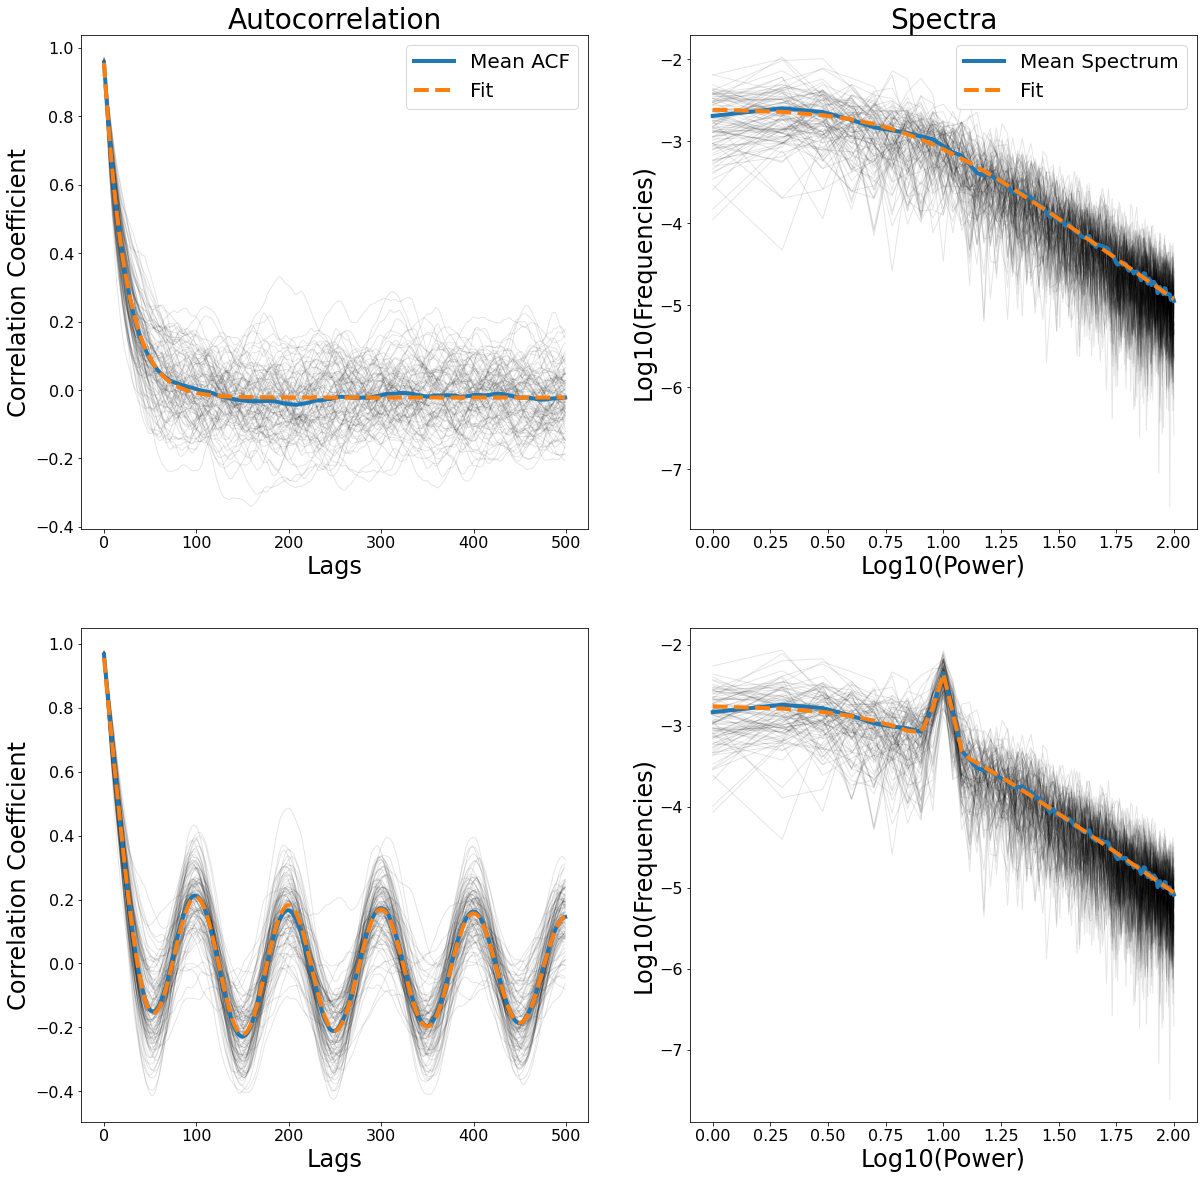

In [3]:
# Plot ACF
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))

for ind, c in enumerate(corrs):
    axes[0][0].plot(c, color='k', alpha=.1, lw=1)
for ind, c in enumerate(corrs_osc):
    axes[1][0].plot(c, color='k', alpha=.1, lw=1)
    
axes[0][0].plot(corrs.mean(axis=0), label=f'Mean ACF', lw=4)
axes[1][0].plot(corrs_osc.mean(axis=0), label=f'Mean ACF', lw=4)


axes[0][0].set_xlabel('Lags', fontsize=24)
axes[1][0].set_xlabel('Lags', fontsize=24)
axes[0][0].set_ylabel('Correlation Coefficient', fontsize=24)
axes[1][0].set_ylabel('Correlation Coefficient', fontsize=24)
     
axes[0][0].tick_params(axis='x', labelsize=16)
axes[0][1].tick_params(axis='x', labelsize=16)
axes[1][0].tick_params(axis='x', labelsize=16)
axes[1][1].tick_params(axis='x', labelsize=16)
axes[0][0].tick_params(axis='y', labelsize=16)
axes[0][1].tick_params(axis='y', labelsize=16)
axes[1][0].tick_params(axis='y', labelsize=16)
axes[1][1].tick_params(axis='y', labelsize=16)

# Plot Spectra
for p in fg.power_spectra:
    axes[0][1].plot(np.log10(fg.freqs), p, color='k', alpha=.1, lw=1)
    
for p in fg_osc.power_spectra:
    axes[1][1].plot(np.log10(fg_osc.freqs), p, color='k', alpha=.1, lw=1)
    
axes[0][1].plot(np.log10(fg.freqs), np.log10(np.mean(10**fg.power_spectra, axis=0)),
                lw=4, color='C0', label='Mean Spectrum')
axes[0][1].set_xlabel('Log10(Power)', fontsize=24)
axes[0][1].set_ylabel('Log10(Frequencies)', fontsize=24)


axes[1][1].plot(np.log10(fg_osc.freqs), np.log10(np.mean(10**fg_osc.power_spectra, axis=0)),
                lw=4, color='C0', label='Mean Spectrum')
axes[1][1].set_xlabel('Log10(Power)', fontsize=24)
axes[1][1].set_ylabel('Log10(Frequencies)', fontsize=24);

axes[0][0].set_title('Autocorrelation', fontsize=28)
axes[0][1].set_title('Spectra', fontsize=28);

# Plt fits
acf_fit = exp_decay_func(np.arange(1, len(corrs[0])+1), fs, *params_acf_mean)
acf_cos_fit = sim_acf_cos(np.arange(1, len(corrs[0])+1), fs, *params_acf_mean_osc)

axes[0][0].plot(acf_fit, label='Fit', color='C1', lw=4, ls='--')
axes[0][1].plot(np.log10(fg_mean.freqs), fg_mean.fooofed_spectrum_, label='Fit', color='C1', lw=4, ls='--')
axes[1][0].plot(acf_cos_fit, color='C1', lw=4, ls='--')
axes[1][1].plot(np.log10(fg_mean_osc.freqs), fg_mean_osc.fooofed_spectrum_, color='C1', lw=4, ls='--')


axes[0][0].legend(fontsize=20, loc='upper right')
axes[0][1].legend(fontsize=20, loc='upper right');
plt.savefig('fig1.png')

### Figure 2

Ground Truth Simulations

- Explain the Convolution + Sampling Method
- Show that methods recapitulate ground truth

In [4]:
from neurodsp.sim import sim_synaptic_kernel

n_seconds = 2
fs = 1000
kernel = sim_synaptic_kernel(5 * tau, fs, 0, tau)
mu = 50

# Pad n_seconds to account for convolution
kern_len = len(kernel[0]) if kernel.ndim == 2 else len(kernel)
times = np.arange(0, int(n_seconds + (kern_len * 2)), 1/fs)

# Randomly sample isi's
isi = np.round_(np.random.exponential(scale=mu, size=len(times))).astype(int)

n_samples = int(n_seconds * fs)
last_ind = np.where(isi.cumsum() >= n_samples)[0]
inds = isi.cumsum() if len(last_ind) == 0 else isi[:last_ind[0]].cumsum()

poisson = np.zeros(len(times), dtype=bool)
poisson[inds] = True

# Convolve the binary poisson array with the kernel
probs = np.convolve(poisson, kernel)[:n_samples]
probs = (probs - np.min(probs)) / np.ptp(probs)

n_neurons = 1
spikes = np.zeros((n_neurons, len(probs)), dtype=bool)
for ind in range(n_neurons):
    spikes[ind] = (probs > np.random.rand(*probs.shape))
    
times = times[:n_samples]
spikes = spikes[0, :n_samples]
poisson = poisson[:n_samples]

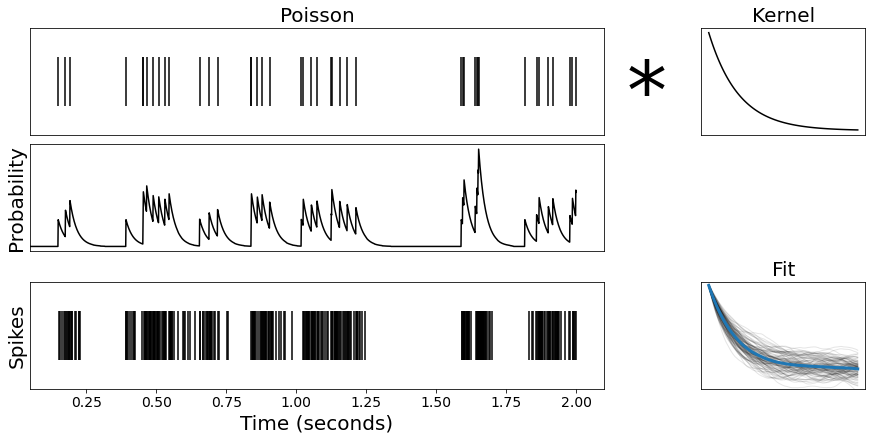

In [5]:
fig = plt.figure(constrained_layout=True, figsize=(12, 6))
gs = fig.add_gridspec(3, 10)

ax0 = fig.add_subplot(gs[0, :7])
ax1 = fig.add_subplot(gs[0, 7:8])
ax2 = fig.add_subplot(gs[0, 8:])
ax3 = fig.add_subplot(gs[1, :7], sharex=ax0)
ax4 = fig.add_subplot(gs[2, :7], sharex=ax0)
ax5 = fig.add_subplot(gs[2, 8:])

ax0.eventplot(times[poisson], color='k')
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax0.set_title('Poisson', size=20)
ax0.set_xlim(times[poisson][0]-.1, times[poisson][-1]+.1)

ax1.text(.2, 0.15, '*', fontdict={'fontsize': 80})
ax1.axis('off')

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.plot(kernel, color='k')
ax2.set_title('Kernel', size=20)

ax3.plot(times, probs, color='k')
ax3.set_ylabel('Probability', size=20)
ax3.set_yticks([])
ax3.get_xaxis().set_visible(False)

ax4.eventplot(times[spikes], color='k')
ax4.set_ylabel('Spikes', size=20)
ax4.set_yticks([])
ax4.tick_params(axis='x', labelsize=14)
ax4.set_xlabel('Time (seconds)', size=20)

for ind, c in enumerate(corrs):
    ax5.plot(c[:125], color='k', alpha=.1, lw=1)
    
ax5.plot(corrs.mean(axis=0)[:125], lw=3)
ax5.set_ylim(-.25, 1)

ax5.get_xaxis().set_visible(False)
ax5.get_yaxis().set_visible(False)
ax5.set_title('Fit', size=20);

plt.savefig('fig2.png')

### Figure 3

Performance of Different Methods

Function of:

- Amount of data (time & number of neurons)
- Oscillatiory Features
- Short vs Long Tau

In [3]:
from copy import deepcopy

def sim_param_grid(fs, f_range, n_iters, param_iters,
                   tau=None, mu=None, psd_bounds=None, acf_bounds=None):

    param =list(param_iters.keys())[0]
    params = param_iters[param]
    taus_acf = np.zeros((len(params), n_iters))
    taus_psd = np.zeros((len(params), n_iters))

    # Ensure f_range is iterable
    f_range = np.array(f_range)

    if f_range.ndim == 1:
        f_range = np.tile(f_range, (len(params), 1))

    acf_bounds_cos = [
        [*acf_bounds[0], None, None, None],
        [*acf_bounds[1], None, None, None]
    ]

    for ind, i in tqdm(enumerate(params), total=len(params)):


        # Determine params
        tau = tau if tau is not None else .01
        tau = i if param == 'taus' else tau

        n_seconds = 50 if param != 'n_seconds' else i

        if param == 'cos_vars':
            # Add oscillation
            _cos = sim_oscillation(n_seconds, fs, 10, phase='max')
            _cos -= _cos.min()
            _cos /= _cos.max()

        # Sample a distribution
        probs = np.zeros((n_iters, int(n_seconds * fs)))

        for j in range(n_iters):
            _probs, _ = sim_spikes_synaptic(n_seconds, fs, tau, mu=mu,
                                            n_neurons=1, return_sum=True)
            if param == 'cos_vars':
                probs[j] = _probs + (_cos * i)
            else:
                probs[j] = _probs

        # Compute ACF
        corrs = compute_acf(probs, 10000)

        if param == 'cos_vars' and i > 0:
            params = fit_acf_cos(corrs, fs, bounds=deepcopy(acf_bounds_cos))
        else:
            params = fit_acf(corrs, fs, bounds=deepcopy(acf_bounds))

        taus_acf[ind] = params[:, 0]

        # Compute PSD
        if param == 'cos_vars' and i > 0:
            fooof_init = {'max_n_peaks': 1}
        else:
            fooof_init = {'max_n_peaks': 0}

        freqs, powers = compute_spectrum(probs, fs, method='medfilt')

        psd_bounds = (0, 1000000) if psd_bounds is None else psd_bounds

        _, _, kf = fit_psd(freqs, powers, tuple(f_range[ind]),
                           fooof_init=fooof_init, knee_bounds=psd_bounds)
        taus_psd[ind] = kf

    return taus_acf, taus_psd


def plot_param_grid(params, taus_est_acf, taus_est_psd, tau_sim, xlabel, ylabel, ax,
                    mode='mean', title=None, xlim=None, ylim=None, plt_log=False, **plt_kwargs):
    
    if mode == 'mean':
        acf_mean = taus_est_acf.mean(axis=1)
        psd_mean = taus_est_psd.mean(axis=1)
    elif mode == 'median':
        acf_mean = np.median(taus_est_acf, axis=1)
        psd_mean = np.median(taus_est_psd, axis=1)
        
    acf_std = taus_est_acf.std(axis=1)
    psd_std = taus_est_psd.std(axis=1)
    
    if plt_log:
        ax.loglog(params, acf_mean, lw=4, color='C0', label='ACF', **plt_kwargs)
        ax.loglog(params, psd_mean, lw=4, color='C1', label='PSD', **plt_kwargs)
    else:
        ax.plot(params, acf_mean, lw=4, color='C0', label='ACF', **plt_kwargs)
        ax.plot(params, psd_mean, lw=4, color='C1', label='PSD', **plt_kwargs)
    
    ax.fill_between(params, acf_mean-acf_std, acf_mean+acf_std, alpha=.2)
    ax.fill_between(params, psd_mean-psd_std, psd_mean+psd_std, alpha=.2)
    
    if tau_sim is not None:
        ax.axhline(tau_sim, lw=4, alpha=0.8, ls='--', color='C2', label='Ground Truth')
    else:
        ax.plot(params, params, lw=4, alpha=0.8, ls='--', color='C2', label='Ground Truth')
        
    ax.tick_params(axis='both', labelsize=20)
    
    ax.set_xlabel(xlabel, size=28)
    ax.set_ylabel(ylabel, size=28)
    
    ax.legend(fontsize=24)
    
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    if title is not None:
        ax.set_title(title, fontsize=30)

In [4]:
# Settings
np.random.seed(0)
fs = 1000
n_iters = 50

knee_freqs= np.arange(1, 51)[::2]
taus = 1./(2*np.pi*knee_freqs)

f_range = np.zeros((len(taus), 2))
f_range[:, 1] = knee_freqs + 50
f_range[:, 0] = .5

acf_bounds = [
    [0.0001, None, None],
    [0.2, None, None]
]

In [15]:
# Time
psd_bounds = [250, 750]
time_iters = {'n_seconds': np.arange(1, 52)[::2]}
taus_acf_time, taus_psd_time = sim_param_grid(fs, f_range[9], n_iters, time_iters,
                                              tau=taus[9], acf_bounds=acf_bounds, psd_bounds=psd_bounds)

  0%|          | 0/26 [00:00<?, ?it/s]

In [7]:
# Tau
taus_iters = {'taus': taus}
taus_acf, taus_psd = sim_param_grid(fs, f_range, n_iters, taus_iters, acf_bounds=acf_bounds)

  0%|          | 0/25 [00:00<?, ?it/s]

In [8]:
# Oscillation
cos_iters = {'cos_vars': np.arange(0, 5) / 10}
taus_acf_cos, taus_psd_cos = sim_param_grid(fs, f_range[9], n_iters, cos_iters, tau=taus[9],
                                            acf_bounds=acf_bounds)

  0%|          | 0/5 [00:00<?, ?it/s]

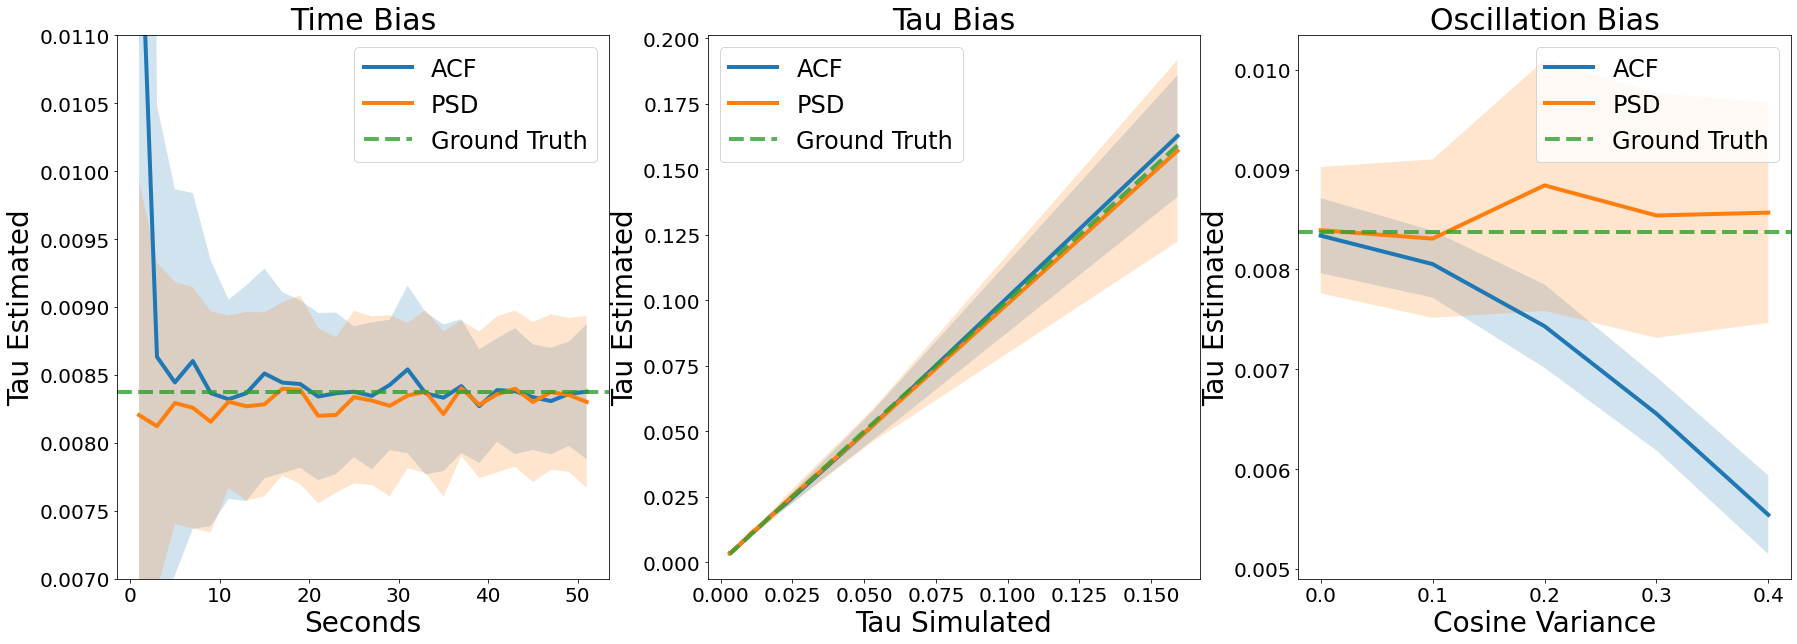

In [17]:
fig, axes = plt.subplots(ncols=3, figsize=(30, 10))

plot_param_grid(time_iters['n_seconds'], taus_acf_time, taus_psd_time, taus[9], 
                'Seconds', 'Tau Estimated', axes[0], mode='mean',
                title='Time Bias', ylim=(.007, 0.011))

plot_param_grid(taus_iters['taus'], taus_acf, taus_psd, None, 
                'Tau Simulated', 'Tau Estimated', axes[1], mode='mean',
                title='Tau Bias')

plot_param_grid(cos_iters['cos_vars'], taus_acf_cos, taus_psd_cos, taus[9], 
                'Cosine Variance', 'Tau Estimated', axes[2], mode='mean',
                title='Oscillation Bias')

plt.savefig('fig3.png')

### Figure 4

Proposed Workflow

1. Determine if oscillations are present
2. If oscillations are presence, remove them using SpecParam
    - Fit the peak removed spectrum with a knee OR
    - Convert the peak removed PSD to ACF and fit using exponential decay.
4. If oscillations are not present, use either method.

Hyper Parameters:
- Presence/Variance of oscillation
- Duration of signal
- Magnitude of tau
- PSD Method
    - Welch v Medfilt v Wavelet
- curve_fit bounds
- curve_fit guess

#### 1. Simulate

In [3]:
# Determine params
n_seconds = 50
fs = 1000

knee_freqs= np.arange(1, 51)[::2]
taus = 1./(2*np.pi*knee_freqs)
tau = taus[9] # corresponds to a 20hz knee
n_seconds = 5
n_iters = 50

_cos = sim_oscillation(n_seconds, fs, 10, phase='max')
_cos -= _cos.min()
_cos /= _cos.max()

# Sample a distribution
probs = np.zeros((n_iters, int(n_seconds * fs)))

for j in range(n_iters):
    _probs, _ = sim_spikes_synaptic(n_seconds, fs, tau,
                                    n_neurons=1, return_sum=True)

    probs[j] = _probs + (_cos * .2)

#### 2. Fit

In [4]:
freq_range=(1, 100)

freqs, powers = compute_spectrum(probs, fs, method='welch', f_range=freq_range)
_freqs, _powers = compute_spectrum(probs, fs, method='welch')

fm = FOOOF(max_n_peaks=1, aperiodic_mode='knee')
fm.fit(freqs, powers.mean(axis=0))

acf = ifft(_powers).real[:, :len(_powers[0])//2]
acf = acf / acf.max()
acf = acf[:, 1:]

inds = [
    np.where(_freqs == fm.freqs[0])[0][0],
    np.where(_freqs == fm.freqs[-1])[0][0] + 1
]

_powers_full = _powers.mean(axis=0).copy()
_powers_full[inds[0]:inds[1]] = 10**fm._spectrum_peak_rm

_corrs_peak_rm = fft(_powers_full).real
_corrs_peak_rm = _corrs_peak_rm[:len(_corrs_peak_rm)//2]
_corrs_peak_rm = _corrs_peak_rm / np.max(_corrs_peak_rm)

_corrs_ap_fit = fft(10**expo_function(_freqs, *fm.aperiodic_params_)).real
_corrs_ap_fit = _corrs_ap_fit[:len(_corrs_ap_fit)//2]
_corrs_ap_fit = _corrs_ap_fit / np.max(_corrs_ap_fit)

lags = np.arange(0, int(2 * len(_corrs_peak_rm)), 2)
lags = lags[1:101]

_corrs_peak_rm = _corrs_peak_rm[1:101]
_corrs_ap_fit = _corrs_ap_fit[1:101]

f_cos, p_cos = compute_spectrum(_cos * .2, fs)

_acf = ifft(p_cos).real[:len(p_cos)//2]
_acf = _acf / _acf.max()
_acf = _acf[1:101]


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



#### 3. Plot

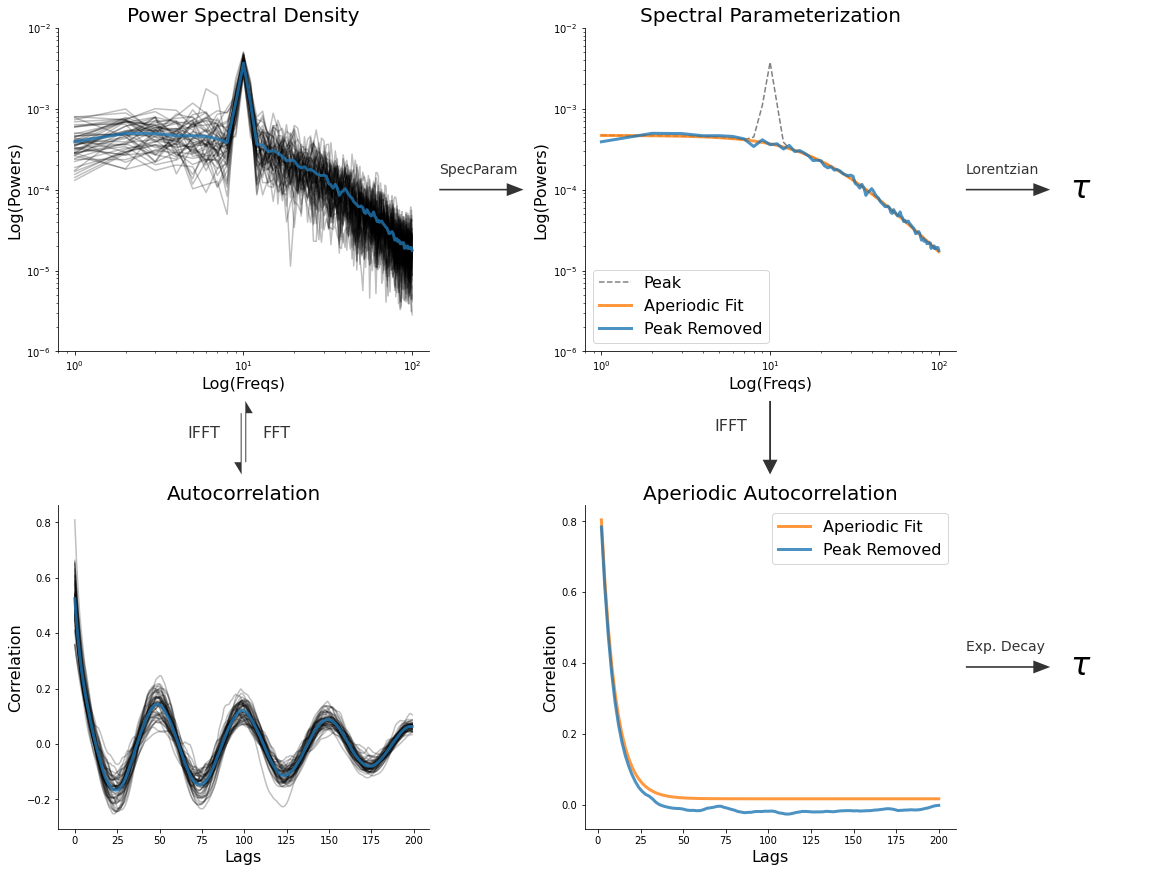

In [5]:
# Configure figure
fig = plt.figure(constrained_layout=True, figsize=(16, 12), facecolor='w')
gs = fig.add_gridspec(9, 11)

ax0 = fig.add_subplot(gs[:4, :4])    # orig spec
ax1 = fig.add_subplot(gs[:4, 4:5])   # arrow
ax2 = fig.add_subplot(gs[:4, 5:9])   # specparam fit
ax3 = fig.add_subplot(gs[:4, 9:10])  # arrow
ax4 = fig.add_subplot(gs[:4, 10:11]) # tau

ax5 = fig.add_subplot(gs[4, :4])     # psd/acf interchange arrows (orig)
ax6 = fig.add_subplot(gs[4, 5:9])    # psd/acf interchange arrows (osc rm)

ax7 = fig.add_subplot(gs[5:, :4])    # acf
ax8 = fig.add_subplot(gs[5:, 5:9])   # acf no osc
ax9 = fig.add_subplot(gs[5:, 9:10])  # arrow
ax10 = fig.add_subplot(gs[5:, 10:11])# tau

# Top Row
for p in powers:
    ax0.loglog(freqs, p, color='k', alpha=.25)
ax0.loglog(freqs, powers.mean(axis=0), lw=3, alpha=.8)
ax0.set_ylim(10**-6, 10**-2)
    
ax2.loglog(fm.freqs, 10**fm.fooofed_spectrum_, color='k', ls='--' , alpha=.5, label='Peak')
ax2.loglog(fm.freqs, 10**fm._ap_fit, label='Aperiodic Fit', color='C1', lw=3, alpha=.8)
ax2.loglog(fm.freqs, 10**fm._spectrum_peak_rm, label='Peak Removed', color='C0', lw=3, alpha=.8)
ax2.legend(fontsize=16)
ax2.set_ylim(10**-6, 10**-2)

ax4.text(.1, -.005, r'$\tau$', size=32)
ax4.set_ylim(-.1, .1)
ax4.set_xlim(0, 1)
ax4.axis('off')

# Transition arrows
arrow_alpha = .8
arrow_color = 'k'

ax1.arrow(*(0, 0), *(1, 0), width=.01, head_width=.08, head_length=.25, shape='full', lw=0,
          color=arrow_color, alpha=arrow_alpha)
ax1.text(0, .1, 'SpecParam', size=14, color=arrow_color, alpha=arrow_alpha)
ax1.set_ylim(-1, 1)
ax1.axis('off')

ax3.arrow(*(0, 0), *(1, 0), width=.01, head_width=.08, head_length=.25, shape='full', lw=0,
         color=arrow_color, alpha=arrow_alpha)
ax3.text(0, .1, 'Lorentzian', size=14, color=arrow_color, alpha=arrow_alpha)
ax3.set_ylim(-1, 1)
ax3.axis('off')

ax5.arrow(*(-.01, 1), *(0, -1), width=.01, head_width=.08, head_length=.25, shape='left', lw=0,
         color=arrow_color, alpha=arrow_alpha)
ax5.arrow(*(.01, 0), *(0, 1), width=.01, head_width=.08, head_length=.25, shape='left', lw=0,
         color=arrow_color, alpha=arrow_alpha)
ax5.text(.1, .5, 'FFT', size=16, color=arrow_color, alpha=arrow_alpha)
ax5.text(-.3, .5, 'IFFT', size=16, color=arrow_color, alpha=arrow_alpha)
ax5.set_xlim(-1, 1)
ax5.axis('off')

ax6.arrow(*(0, 1), *(0, -1), width=.01, head_width=.08, head_length=.25, shape='full', lw=0,
         color=arrow_color, alpha=arrow_alpha)
ax6.text(-.3, .5, 'IFFT', size=16, color=arrow_color, alpha=arrow_alpha)
ax6.set_xlim(-1, 1)
ax6.axis('off')

ax9.arrow(*(0, 0), *(1, 0), width=.01, head_width=.08, head_length=.25, shape='full', lw=0,
         color=arrow_color, alpha=arrow_alpha)
ax9.text(0, .1, 'Exp. Decay', size=14, color=arrow_color, alpha=arrow_alpha)
ax9.set_ylim(-1, 1)
ax9.axis('off')

# Bottom row
for a in acf:
    ax7.plot(a[:200], color='k', alpha=.25)
ax7.plot(acf.mean(axis=0)[:200], lw=3, alpha=.8)

ax8.plot(lags, _corrs_ap_fit, label='Aperiodic Fit', color='C1', lw=3, alpha=.8)
ax8.plot(lags, _corrs_peak_rm, label='Peak Removed', color='C0', lw=3, alpha=.8)
ax8.legend(fontsize=16)

ax10.text(.1, -.005, r'$\tau$', size=32)
ax10.set_ylim(-.1, .1)
ax10.set_xlim(0, 1)
ax10.axis('off')

# Axes updates
ax0.set_title('Power Spectral Density', size=20)
ax0.set_xlabel('Log(Freqs)', fontsize=16)
ax0.set_ylabel('Log(Powers)', fontsize=16)

ax2.set_title('Spectral Parameterization', size=20)
ax2.set_xlabel('Log(Freqs)', fontsize=16)
ax2.set_ylabel('Log(Powers)', fontsize=16)

ax7.set_title('Autocorrelation', size=20)
ax7.set_xlabel('Lags', fontsize=16)
ax7.set_ylabel('Correlation', fontsize=16)

ax8.set_title('Aperiodic Autocorrelation', size=20)
ax8.set_xlabel('Lags', fontsize=16)
ax8.set_ylabel('Correlation', fontsize=16)


for _ax in [ax0, ax2, ax7, ax8]:
    _ax.spines['right'].set_visible(False)
    _ax.spines['top'].set_visible(False)
    _ax.yaxis.set_ticks_position('left')
    _ax.xaxis.set_ticks_position('bottom')
    
plt.savefig('fig4.png')

In [9]:
freq_range=(1, 100)

freqs, powers = compute_spectrum(probs, fs, method='welch', f_range=freq_range)
peak_rm_powers = np.zeros((len(powers), len(freqs)))

knee_freqs = np.zeros(len(powers))
knee_taus = np.zeros(len(powers))

for ind, p in enumerate(powers):
    fm = FOOOF(aperiodic_mode='knee', max_n_peaks=1, verbose=False)
    fm.fit(freqs, p, freq_range=freq_range)
    
    knee = fm.get_params('aperiodic', 'knee')
    exp = fm.get_params('aperiodic', 'exponent')

    knee_freq, knee_tau = convert_knee_val(knee, exponent=exp)
    knee_freqs[ind] = knee_freq
    knee_taus[ind] = knee_tau
    
    peak_rm_powers[ind] = fm._spectrum_peak_rm

In [10]:
# Remove peaks from full spectra
#   using the full spectra for the next ifft step produces better results
freqs_full, powers_full = compute_spectrum(probs, fs, method='welch')

for ind, p in enumerate(peak_rm_powers):
    powers_full[ind, freqs.astype(int)] = 10**p

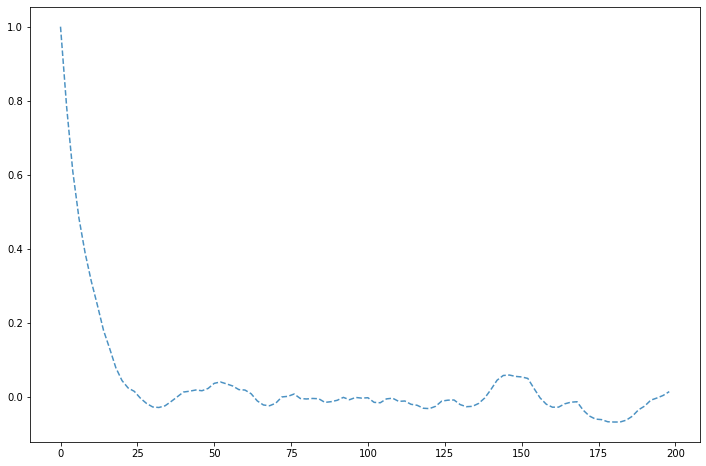

In [14]:
# Use ifft to return ACF, with the oscillitory component removed.
corrs_ifft = ifft(powers_full).real

for i in range(len(corrs_ifft)):
    corrs_ifft[i] = corrs_ifft[i] / np.max(corrs_ifft[i])
    corrs_ifft[i] = corrs_ifft[i] * np.max(corrs_ifft[i])
    
lags = np.arange(0, int(2 * len(corrs_ifft[0])), 2)

plt.figure(figsize=(12, 8))
plt.plot(lags[:100], corrs_ifft[0][:100], ls='--', alpha=.8);

In [15]:
corrs = compute_acf(probs, 200)
acf_taus = fit_acf(corrs, fs)[:, 0]
acf_taus_ifft = fit_acf(corrs_ifft[:, :100], fs)[:, 0] * 2
_, _, psd_taus = fit_psd(freqs, powers, (1, 100))

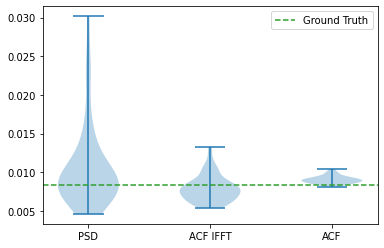

In [16]:
plt.violinplot([psd_taus, acf_taus_ifft, acf_taus])
plt.xticks([1, 2, 3], ['PSD', 'ACF IFFT', 'ACF'])
plt.axhline(tau, color='C2', ls='--', label='Ground Truth')
plt.legend();